In [38]:
#pip install gensim==3.8.3

In [39]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from keras import backend as K 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

In [40]:
data = pd.read_csv('tatarstan_message_2.csv', sep = ',')
print(data.columns)
data = data[['categories', 'description_stem']]
data.head(3)

Index(['level_0', 'index', 'categories', 'description', 'worker',
       'description_prep', 'num_words', 'description_stem'],
      dtype='object')


,categories,description_stem
0,Благоустройство территории,трасса нижнекамск чистополь лесополоса пгт кам...
1,Благоустройство территории,двор дом ленинградский отсутствовать парковочн...
2,Содержание и ремонт муниципальных дорог,добрый день осуществляться уборка снег центр г...


In [41]:
data = data.dropna()
text_train = data['description_stem'].to_list()

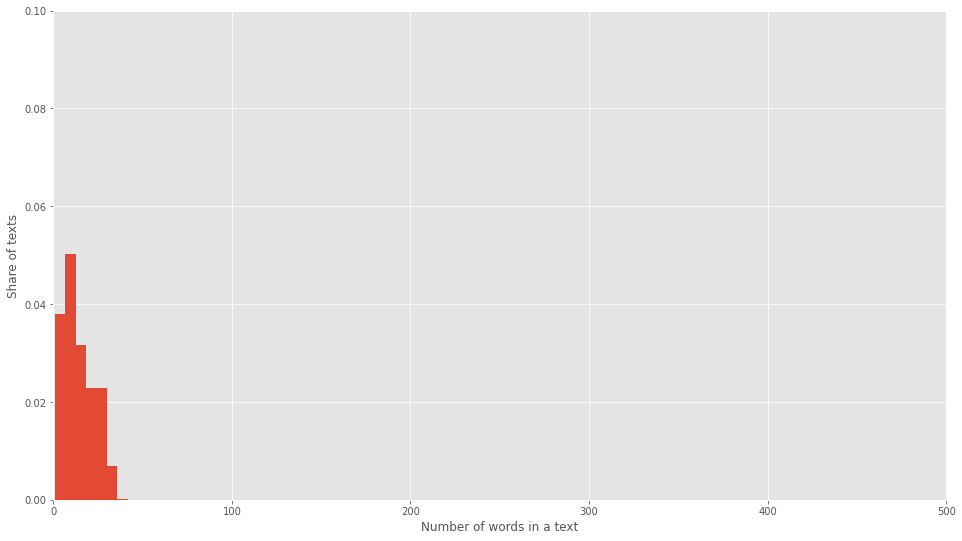

In [42]:
#гистограмма наиболее часто встречающегося количества слов
plt.style.use('ggplot')

plt.figure(figsize=(16, 9)) 
# facecolor='g'
len_of_sent = data['description_stem'].apply(lambda x: len(x.split(' ')))
n, bins, patches = plt.hist(len_of_sent, 500, density=True)
plt.xlabel('Number of words in a text')
plt.ylabel('Share of texts')
plt.axis([0, 500, 0, 0.1])
plt.grid(True)
plt.show()

#выбираем количество анализируемых слов = 30

In [43]:
#загрузка модели Word2Vec
model = Word2Vec.load("/notebooks/w2v_model/tweets_model.w2v")
model.delete_temporary_training_data()

In [44]:
#загрузка эмбеддингов из словаря модели
e_matrix = []
mydict = []
for word in model.wv.vocab.keys():
    try:
        e_matrix.append(model.wv[word])
        mydict.append(word)
        if len(e_matrix) >= 200000:
            break
    except:
        print("Пропущено слово при заполнении модели")
        continue

print(f"Размерность словаря для embedding {len(e_matrix)}")

NUM = len(e_matrix)
e_matrix = np.array(e_matrix, dtype=object)

Размерность словаря для embedding 200000


In [45]:
DIM = model.vector_size
print(DIM)
print(NUM)
tokenizer = Tokenizer(oov_token = True) #num_words = NUM
tokenizer.fit_on_texts(mydict)

SENTENCE_LENGTH = 50

print("подготовка обучающего набора")
raw_data = [row.split(' ') for row in data['description_stem']]
X = tokenizer.texts_to_sequences(raw_data) 
X = pad_sequences(X, maxlen=SENTENCE_LENGTH)
print(f"Количество слов в предложении: {len(X[0])}")
print(X.shape)
print(X)

Y = pd.get_dummies(data['categories'])
label_columns=Y.columns #To get the classes
Y = Y.to_numpy() #Convert labels to numpy array
print(Y.shape)
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

200
200000
подготовка обучающего набора
Количество слов в предложении: 50
(23670, 50)
[[    0     0     0 ... 44432 30966 81127]
 [    0     0     0 ...  5839  5959   594]
 [    0     0     0 ... 81127  2522 84833]
 ...
 [    0     0     0 ... 19103  2997 53564]
 [    0     0     0 ... 39383 35712   373]
 [65932 45762     1 ... 23944     1  9070]]
(23670, 26)
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [46]:
# Метрики 
from sklearn.metrics import matthews_corrcoef
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [47]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

SENTENCE_LENGTH = 50
NUM = 200000
DIM = 200

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32') 
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH, weights=[e_matrix], trainable=False)(tweet_input) #Слой Emdedding

branches = []

x = Dropout(0.1)(tweet_encoder)
for size in [2, 3, 4, 5]:
    branch = Conv1D(filters=50, kernel_size=size, padding='valid', activation='relu')(x)
    branch = GlobalMaxPooling1D()(branch)
    branches.append(branch)
x = concatenate(branches, axis=1)
x = Dropout(0.1)(x)
x = Dense(300, activation='relu')(x)
output = Dense(26, activation='softmax')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 200)      40000000    input_4[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 50, 200)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 49, 50)       20050       dropout_5[0][0]                  
____________________________________________________________________________________________

In [48]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("cnn_weights/CNN_Word2Vec_100000-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=512, epochs=100, validation_split=0.1, callbacks = [checkpoint])

Epoch 1/100
34/34 [==============================] - 2s 33ms/step - loss: 0.3290 - accuracy: 0.3442 - precision: 0.3674 - recall: 0.2236 - f1: 0.2563 - val_loss: 0.0931 - val_accuracy: 0.5544 - val_precision: 0.6110 - val_recall: 0.4299 - val_f1: 0.5047
Epoch 2/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0939 - accuracy: 0.5501 - precision: 0.5826 - recall: 0.4922 - f1: 0.5335 - val_loss: 0.0837 - val_accuracy: 0.5876 - val_precision: 0.6568 - val_recall: 0.4515 - val_f1: 0.5351
Epoch 3/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0813 - accuracy: 0.5931 - precision: 0.6279 - recall: 0.5416 - f1: 0.5814 - val_loss: 0.0783 - val_accuracy: 0.6304 - val_precision: 0.7001 - val_recall: 0.5054 - val_f1: 0.5869
Epoch 4/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0760 - accuracy: 0.6184 - precision: 0.6624 - recall: 0.5616 - f1: 0.6075 - val_loss: 0.0733 - val_accuracy: 0.6573 - val_precision: 0.7100 - val_recall: 0.5786 -

Epoch 33/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0248 - accuracy: 0.8909 - precision: 0.9023 - recall: 0.8807 - f1: 0.8913 - val_loss: 0.0638 - val_accuracy: 0.7133 - val_precision: 0.7330 - val_recall: 0.6914 - val_f1: 0.7116
Epoch 34/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0244 - accuracy: 0.8931 - precision: 0.9047 - recall: 0.8831 - f1: 0.8938 - val_loss: 0.0657 - val_accuracy: 0.7064 - val_precision: 0.7173 - val_recall: 0.6867 - val_f1: 0.7017
Epoch 35/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0238 - accuracy: 0.8948 - precision: 0.9044 - recall: 0.8856 - f1: 0.8949 - val_loss: 0.0650 - val_accuracy: 0.7159 - val_precision: 0.7311 - val_recall: 0.6911 - val_f1: 0.7105
Epoch 36/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0238 - accuracy: 0.8938 - precision: 0.9052 - recall: 0.8868 - f1: 0.8959 - val_loss: 0.0651 - val_accuracy: 0.7122 - val_precision: 0.7224 - val_recall: 0.69

34/34 [==============================] - 1s 18ms/step - loss: 0.0137 - accuracy: 0.9449 - precision: 0.9482 - recall: 0.9403 - f1: 0.9442 - val_loss: 0.0775 - val_accuracy: 0.7223 - val_precision: 0.7317 - val_recall: 0.7104 - val_f1: 0.7209
Epoch 66/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0129 - accuracy: 0.9440 - precision: 0.9476 - recall: 0.9415 - f1: 0.9445 - val_loss: 0.0774 - val_accuracy: 0.7260 - val_precision: 0.7324 - val_recall: 0.7148 - val_f1: 0.7235
Epoch 67/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0131 - accuracy: 0.9431 - precision: 0.9471 - recall: 0.9406 - f1: 0.9439 - val_loss: 0.0770 - val_accuracy: 0.7196 - val_precision: 0.7280 - val_recall: 0.7090 - val_f1: 0.7183
Epoch 68/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0131 - accuracy: 0.9451 - precision: 0.9497 - recall: 0.9416 - f1: 0.9457 - val_loss: 0.0801 - val_accuracy: 0.7165 - val_precision: 0.7224 - val_recall: 0.7079 - val_f1: 

34/34 [==============================] - 1s 19ms/step - loss: 0.0092 - accuracy: 0.9616 - precision: 0.9635 - recall: 0.9602 - f1: 0.9618 - val_loss: 0.0932 - val_accuracy: 0.7122 - val_precision: 0.7130 - val_recall: 0.7065 - val_f1: 0.7097
Epoch 98/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0094 - accuracy: 0.9601 - precision: 0.9621 - recall: 0.9586 - f1: 0.9603 - val_loss: 0.0912 - val_accuracy: 0.7228 - val_precision: 0.7262 - val_recall: 0.7192 - val_f1: 0.7227
Epoch 99/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0096 - accuracy: 0.9601 - precision: 0.9616 - recall: 0.9588 - f1: 0.9602 - val_loss: 0.0899 - val_accuracy: 0.7144 - val_precision: 0.7168 - val_recall: 0.7085 - val_f1: 0.7126
Epoch 100/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0092 - accuracy: 0.9642 - precision: 0.9669 - recall: 0.9626 - f1: 0.9648 - val_loss: 0.0889 - val_accuracy: 0.7228 - val_precision: 0.7231 - val_recall: 0.7155 - val_f1:

In [50]:
model.load_weights('cnn_weights/CNN_Word2Vec_100000-61-0.73.hdf5')

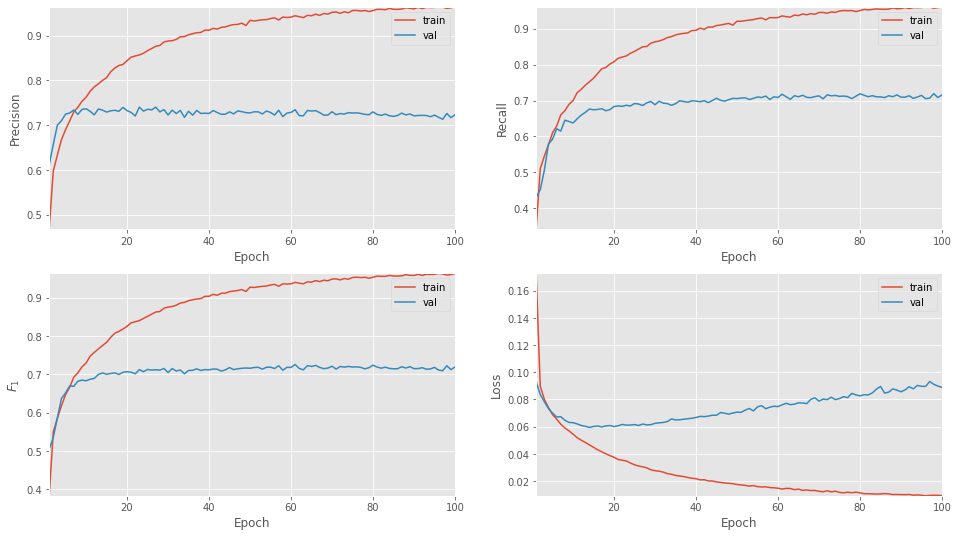

In [51]:
plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    #plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [52]:
from sklearn.metrics import classification_report
print("Оценки тестового набора:")
predicted = np.array(model.predict(X_test))
predicted = np.argmax(predicted, axis=1)
Y_test = np.array(Y_test)
Y_test_ = np.argmax(Y_test, axis = 1)
print(classification_report(Y_test_, predicted, digits=3))
print(matthews_corrcoef(Y_test_, predicted))

Оценки тестового набора:
              precision    recall  f1-score   support

           0      0.629     0.549     0.586        71
           1      0.881     0.828     0.853       116
           2      0.746     0.768     0.757      2196
           3      0.000     0.000     0.000         4
           4      0.677     0.677     0.677        31
           5      0.333     0.107     0.162        28
           6      0.636     0.500     0.560        14
           7      0.000     0.000     0.000         6
           8      0.475     0.704     0.567        27
           9      0.909     0.789     0.845        38
          10      0.828     0.757     0.791       210
          12      0.799     0.588     0.677       182
          13      0.000     0.000     0.000         2
          14      0.741     0.793     0.766       324
          15      0.320     0.116     0.170        69
          16      0.866     0.750     0.804       112
          17      0.667     0.500     0.571         8
  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[precision, recall, f1])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 200)      40000000    input_4[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 50, 200)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 49, 50)       20050       dropout_5[0][0]                  
____________________________________________________________________________________________

In [54]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("cnn_weights/CNN_Word2Vec_2-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(X_train, Y_train, batch_size=128, epochs=30, validation_split=0.1, callbacks = [checkpoint])

Epoch 1/30
134/134 [==============================] - 54s 393ms/step - loss: 0.0174 - precision: 0.9324 - recall: 0.9210 - f1: 0.9266 - val_loss: 0.0728 - val_precision: 0.7275 - val_recall: 0.7078 - val_f1: 0.7175
Epoch 2/30
134/134 [==============================] - 53s 396ms/step - loss: 0.0169 - precision: 0.9320 - recall: 0.9215 - f1: 0.9267 - val_loss: 0.0721 - val_precision: 0.7359 - val_recall: 0.7134 - val_f1: 0.7245
Epoch 3/30
134/134 [==============================] - 52s 386ms/step - loss: 0.0146 - precision: 0.9438 - recall: 0.9348 - f1: 0.9392 - val_loss: 0.0748 - val_precision: 0.7348 - val_recall: 0.7153 - val_f1: 0.7248
Epoch 4/30
134/134 [==============================] - 53s 393ms/step - loss: 0.0135 - precision: 0.9463 - recall: 0.9395 - f1: 0.9428 - val_loss: 0.0748 - val_precision: 0.7351 - val_recall: 0.7149 - val_f1: 0.7248
Epoch 5/30
134/134 [==============================] - 51s 379ms/step - loss: 0.0118 - precision: 0.9549 - recall: 0.9489 - f1: 0.9519 - val_

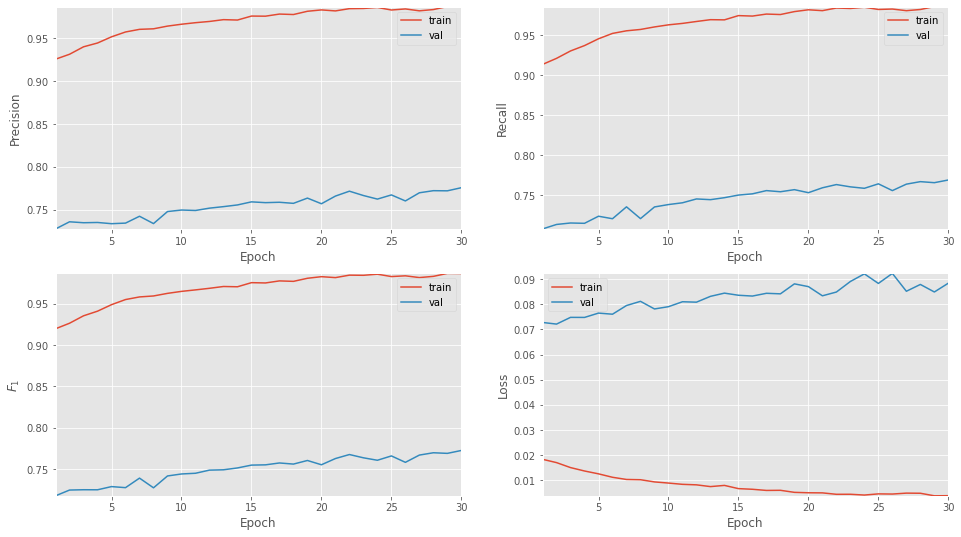

In [55]:
plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    #plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history_trainable)

In [56]:
from sklearn.metrics import classification_report
print("Оценки тестового набора:")
predicted = np.array(model.predict(X_test))
predicted = np.argmax(predicted, axis=1)
Y_test = np.array(Y_test)
Y_test_ = np.argmax(Y_test, axis = 1)
print(classification_report(Y_test_, predicted, digits=3))
print(matthews_corrcoef(Y_test_, predicted))

Оценки тестового набора:
              precision    recall  f1-score   support

           0      0.667     0.535     0.594        71
           1      0.899     0.922     0.911       116
           2      0.786     0.813     0.800      2196
           3      0.000     0.000     0.000         4
           4      0.826     0.613     0.704        31
           5      0.333     0.071     0.118        28
           6      0.750     0.429     0.545        14
           7      0.333     0.167     0.222         6
           8      0.643     0.667     0.655        27
           9      0.917     0.868     0.892        38
          10      0.876     0.805     0.839       210
          12      0.872     0.709     0.782       182
          13      1.000     0.500     0.667         2
          14      0.822     0.769     0.794       324
          15      0.448     0.188     0.265        69
          16      0.897     0.777     0.833       112
          17      1.000     0.500     0.667         8
  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
